# Курсовой проект для курса "Python для Data Science"

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Соревнование заканчивается 20.12.20
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

- Файл должен содержать заголовки и комментарии
- Повторяющиеся операции лучше оформлять в виде функций
- По возможности добавлять графики, описывающие данные (около 3-5)
- Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
- Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
- Весь проект должен быть в одном скрипте (файл ipynb).
- При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
- Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Подключение библиотек и скриптов

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score as r2

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math as math
import sklearn

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print(f'В трейне строк: {train_df.shape[0]} и колонок: {train_df.shape[1]}')
print(f'В тесте строк:  {test_df.shape[0]}  и колонок: {test_df.shape[1]}')

В трейне строк: 10000 и колонок: 20
В тесте строк:  5000  и колонок: 19


## **1. EDA**

### целевая переменная

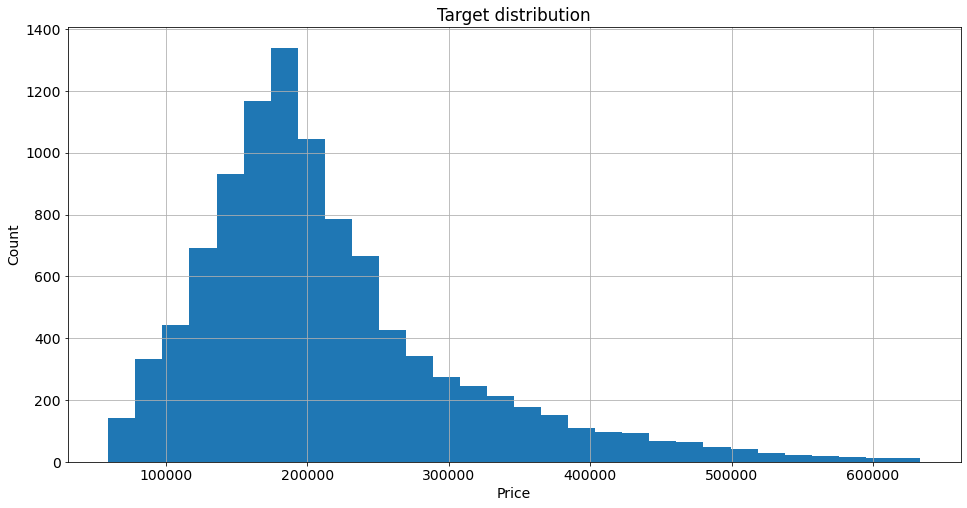

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Площаль по комнатам явно показывает на неадекватность данных, нужно будет поправлять

Text(0.5, 1.0, 'Распредение общей площади по количеству комнат')

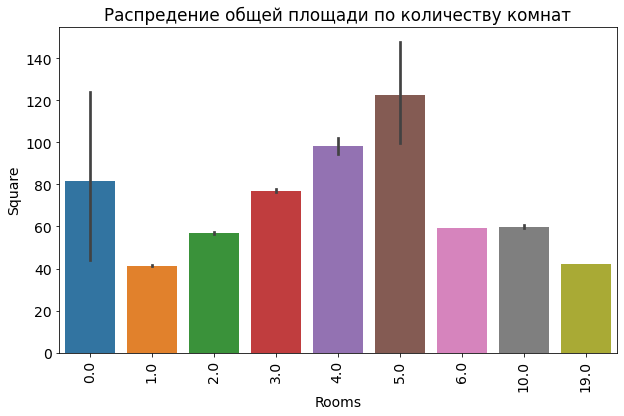

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(train_df['Rooms'], train_df['Square'])
plt.xticks(rotation=90)
plt.title('Распредение общей площади по количеству комнат')

Среднее значение по площади квартир схожей комнатности не сильно отличается от медианного значения.
Следовательно для ненормированных значений комнат (0 или больше 5 шт) их лучше приравнять к медиане.

In [12]:
train_df.groupby(['Rooms'])['Square'].agg(['max', 'min', 'mean', 'median']).round(0)

,max,min,mean,median
Rooms,,,,
0.0,213.0,2.0,82.0,65.0
1.0,409.0,1.0,41.0,40.0
2.0,641.0,5.0,57.0,56.0
3.0,191.0,4.0,77.0,77.0
4.0,200.0,44.0,98.0,99.0
5.0,276.0,40.0,123.0,116.0
6.0,59.0,59.0,59.0,59.0
10.0,61.0,59.0,60.0,60.0
19.0,42.0,42.0,42.0,42.0


Text(0.5, 1.0, 'Distribution of variable House Year')

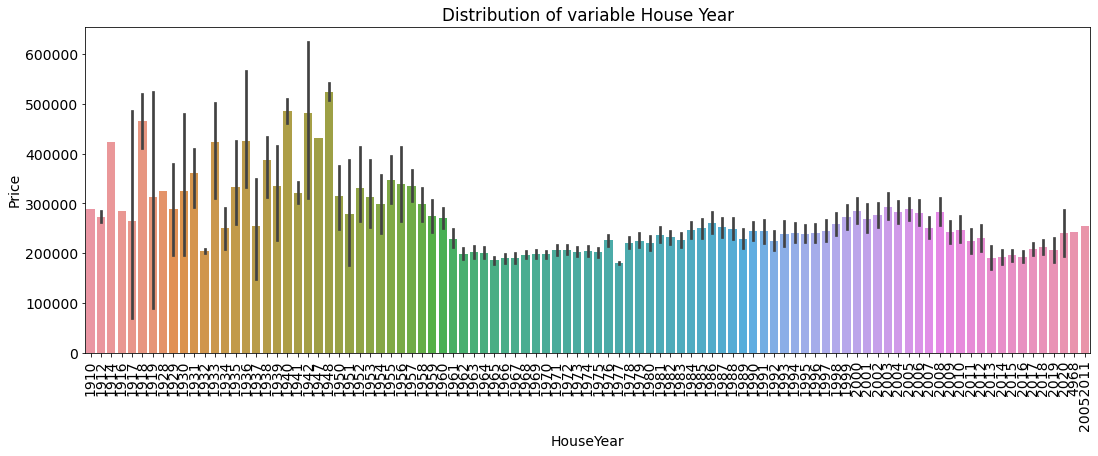

In [13]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['HouseYear'], train_df['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

Этажность варьируется немного неадекватно, есть 0 этаж и супер высокие.
Будем заменять на средние значения по распределению по годам (условное среднее на по графику выше)

Text(0.5, 1.0, 'Distribution of variable HouseFloor')

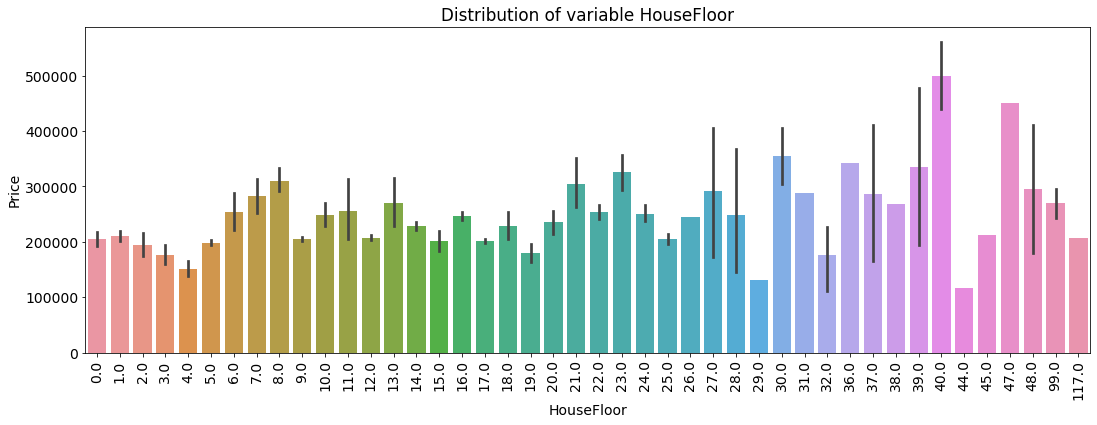

In [14]:
plt.figure(figsize=(18, 6))
sns.barplot(train_df['HouseFloor'], train_df['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable HouseFloor')

In [15]:
train_df.groupby('Rooms')[['Square', 'LifeSquare', 'KitchenSquare']].median()

,Square,LifeSquare,KitchenSquare
Rooms,,,
0.0,65.487474,85.125471,0.0
1.0,40.406590,21.663929,6.0
2.0,55.841812,32.552134,6.0
3.0,77.413643,46.960480,7.0
4.0,98.668054,64.946548,9.0
5.0,116.084861,80.458910,9.0
6.0,59.414334,38.702244,6.0
10.0,59.964120,37.321877,10.0
19.0,42.006046,21.779288,7.0


Есть неадекватное количество комнат и неадекватные площади

Если

1. Rooms = 0 
2. AverageRoomSquare < 10 

то подбираем количество комнат по медианной площади комнаты

Далее опираться будем на количество комнат

Жилая площадь = Общая площадь - Кухня - (коридоры, холлы, санузлы). Последнее слагаемое неизвестно. Добавим фичи:

1. Площадь доп помещений OtherSquare

2. Средняя площадь комнаты AverageRoomSquare (вычитая из общей площади 13 квадратов (кухню, коридор, уборную))

3. Цена квадратного метра Price_metre


In [16]:
train_df['Price_metre'] = round(train_df.Price / train_df.Square, 2)
train_df.groupby('DistrictId')['Price_metre'].mean()

DistrictId
0      3710.400208
1      3522.839417
2      4560.204359
3      3783.789878
4      5247.141818
          ...     
202    7447.525000
205    5101.020000
207    5550.680000
208    8005.605000
209    4176.440000
Name: Price_metre, Length: 205, dtype: float64

Удание строк с неадекватной площадью хуже сказывается на обучении. Эффективнее заменить на площадь по формуле = (цена квартиры) / (средняя цена за кв метр по району)

In [17]:
train_df[(train_df['Square'] < 13) ^ (train_df['Square'] > 400)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_metre
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,148259.79
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,36757.84
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,310.43
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,72032.84
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,230463.54
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,107329.94
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,23223.12
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,220.97
7033,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,75042.11
7470,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,159593.11


In [18]:
class DataPreprocessing:
    
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def add_control_features(self, X):
        # дополнительные признаки для анализа выбросов и дальнейшего использования
        X['OtherSquare'] = X.Square - X.LifeSquare - X.KitchenSquare
        X['AverageRoomSquare'] = (X.Square - 13) / X.Rooms
        X['FirstOrLastfloor'] = 0
        
        return X

        
    def fix_rooms(self, df):

        #Готовим медианные площади для подбора количества комнат
        Median_square = df.groupby('Rooms')[['Square', 'AverageRoomSquare']].median()    

        print(Median_square)

        #Проходим строки и подбираем количество комнат
        for idx, row in df.iterrows():

            #Строки с адекватными значениями не трогаем
            if (0 < row.Rooms < 6) and (row.AverageRoomSquare > 10):
                continue

            print(f"Было Rooms: {row.Rooms}, Square {row.Square}")
            #Подбираем количество комнат исходя их средних значений медиан по площади квартир

            if row.Square < 45:
                df.loc[idx, 'Rooms'] = 1
                print(f"Стало Rooms: 1, Square {row.Square}")           
                continue
            elif row.Square < 62:
                df.loc[idx, 'Rooms'] = 2
                print(f"Наконец-то Стало Rooms: 2, Square {row.Square}")           
                continue
            elif row.Square < 82:
                df.loc[idx, 'Rooms'] = 3
                print(f"Наконец-то Стало Rooms: 3, Square {row.Square}")           
                continue
            elif row.Square < 101:
                df.loc[idx, 'Rooms'] = 4
                print(f"Наконец-то Стало Rooms: 4, Square {row.Square}")           
                continue
            else:
                df.loc[idx, 'Rooms'] = 5
                print(f"Наконец-то Стало Rooms: 5, Square {row.Square}")           
                continue

        # Еще раз посчитаем AverageRoomSquare
        df['AverageRoomSquare'] = (df.Square - 13) / df.Rooms    
        
        
    def fix_square(self, df):
        
        Median_square = df.groupby('Rooms')[['Square', 'LifeSquare', 'KitchenSquare']].median()
        
        if 'Price_metre' in df.columns:
            Median_price = df.groupby('DistrictId')['Price_metre'].mean()
            for idx, row in df.iterrows():
                if (row.Square > 400 or row.Square < 13):
                    df.loc[idx, 'Square'] = row.Price / Median_price.loc[row.DistrictId]
                    
                    # если цена квартиры отличается в 4 раза от средней по району то заменяем этот выброс на среднюю
                if (row.Price > Median_price.loc[row.DistrictId] * row.Square * 4) or \
                (row.Price < Median_price.loc[row.DistrictId] * row.Square / 4):
                    df.loc[idx, 'Price'] = Median_price.loc[row.DistrictId] * row.Square
        else:
            for idx, row in df.iterrows():
                if (row.Square > 400 or row.Square < 13):
                    df.loc[idx, 'Square'] = Median_square.loc[row.Rooms].Square
                
           
        for idx, row in df.iterrows():
            if (row.KitchenSquare > 20 or row.KitchenSquare > row.Square / 3 or row.KitchenSquare < 7):
                df.loc[idx, 'KitchenSquare'] = Median_square.loc[row.Rooms].KitchenSquare

        #Пересчитываем доп площадь, если она отрицательная, то нужно исправлять жилую площадь
        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare            

        #Исправляем жилую площадь
        #Если LifeSquare слишком маленькая или OtherSquare < 0 
        for idx, row in df.iterrows():
            if row.Rooms > 0:
                if (row.OtherSquare < 0) or ((row.LifeSquare / row.Rooms) < 20):
                    df.loc[idx, 'LifeSquare'] = row.Square - 13

        #Еще раз пересчитываем доп площадь
        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare 
        
        return df 
        
    def fix_Floor(self, df):

        current_year = datetime.now().year

        index_to_do = df[(df['HouseFloor'] > 25)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'] = 25
            
        index_to_do = df[(df['HouseFloor'] == 0)].index
        for idx in index_to_do:
            if df.loc[idx, 'HouseYear'] < 1970:
                df.loc[idx, 'HouseFloor'] = 6
            elif df.loc[idx, 'HouseYear'] < 1985:
                df.loc[idx, 'HouseFloor'] = 12
            else:
                df.loc[idx, 'HouseFloor'] = 16

        #Если год постройки > текущего то 2020   
        index_to_do = df[df['HouseYear'] > current_year].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = 2020

        #Если этаж квартиры больше этажа сдания то увеличим этажность дома
        index_to_do = df[df['HouseFloor'] < df['Floor']].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'] = df.loc[idx, 'Floor']   
        
        
        # Добавяем переменную 1 и последнего этажа, который возможно влияет на цену
        index_to_do = df[(df['Floor'] == 1)].index
        for idx in index_to_do:
            df.loc[idx, 'FirstOrLastfloor'] = 1
            
        index_to_do = df[(df['Floor'] == df['HouseFloor'])].index
        for idx in index_to_do:
            df.loc[idx, 'FirstOrLastfloor'] = 1

            
    def fill_NAN(self, df):
        # Заполним OtherSquare нулями
        df['OtherSquare'].fillna(0, inplace = True)

        # Заполним LifeSquare = Square - KitchenSquare - OtherSquare
        index_to_do = df.loc[df['LifeSquare'].isnull()].index
        for idx in index_to_do:
            df.loc[idx, 'LifeSquare'] = df.loc[idx, 'Square'] - df.loc[idx, 'KitchenSquare'] - df.loc[idx, 'OtherSquare']
    
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()

        # дополнительные признаки для анализа выбросов
        X['Price_metre'] = round(X.Price / X.Square, 2)        
        
        return X
    
    
    def transform(self, X):
        """Трансформация данных"""
        
        self.fix_square(X)
        self.fix_rooms(X)
        self.fix_square(X)
        self.fix_Floor(X) 
        
        # Заполним LifeSquare, Healthcare1
        self.fill_NAN(X)    
        
        # Приведение типов
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)   
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [19]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_district1 = None
        self.med_price_by_floor_year = None
        self.med_price_by_year = None
        self.med_price_by_floor = None
        self.house_year_max = None
        self.floor_max = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
                
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_district1 = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict1'})
            self.med_price_by_district_median1 = self.med_price_by_district1['MedPriceByDistrict1'].median()   
            
        if y is not None:  
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price_metre':'mean'})\
                                            .rename(columns={'Price_metre':'MedPriceByDistrict'})    
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()   
            
        if y is not None:
            self.floor_max = df['Floor'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            self.med_price_by_floor = df.groupby(['floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloor'})
            self.med_price_by_floor_median = self.med_price_by_floor['MedPriceByFloor'].median()  
            
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_year = df.groupby(['year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
            self.med_price_by_year_median = self.med_price_by_year['MedPriceByYear'].median()  
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')  
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_district1 is not None:
            X = X.merge(self.med_price_by_district1, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median1, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)        
            
        if self.med_price_by_year is not None:
            X = X.merge(self.med_price_by_year, on=['year_cat'], how='left')
            X.fillna(self.med_price_by_year_median, inplace=True)  
            
        if self.med_price_by_floor is not None:
            X = X.merge(self.med_price_by_floor, on=['floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_median, inplace=True)  
 
        return X
    
    def floor_to_cat(self, X):
            bins = [1, 5, 9, 12, 16, self.floor_max]
            X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
            X['floor_cat'].fillna(-1, inplace=True) 
            return X
     
    def year_to_cat(self, X):
        bins = [0, 1960, 1975, 1997, 2008, 2019, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X        

In [20]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()

train_df = preprocessor.add_control_features(train_df)
test_df = preprocessor.add_control_features(test_df)

train_df = preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df = preprocessor.fit(train_df)

train_df.shape, test_df.shape

           Square  AverageRoomSquare
Rooms                               
0.0     65.487474                inf
1.0     40.422992          27.406590
2.0     55.841812          21.420906
3.0     77.413643          21.471214
4.0     98.668054          21.417013
5.0    116.084861          20.616972
6.0     59.414334           7.735722
10.0    59.964120           4.696412
19.0    42.006046           1.526634
Было Rooms: 1.0, Square 68.4566318457056
Наконец-то Стало Rooms: 3, Square 68.4566318457056
Было Rooms: 1.0, Square 20.92492649860907
Стало Rooms: 1, Square 20.92492649860907
Было Rooms: 3.0, Square 55.41383580171701
Наконец-то Стало Rooms: 2, Square 55.41383580171701
Было Rooms: 1.0, Square 22.072457237900824
Стало Rooms: 1, Square 22.072457237900824
Было Rooms: 4.0, Square 44.12894658117814
Стало Rooms: 1, Square 44.12894658117814
Было Rooms: 1.0, Square 20.213127721198227
Стало Rooms: 1, Square 20.213127721198227
Было Rooms: 1.0, Square 55.28319960121393
Наконец-то Стало Rooms: 2, Sq

((10000, 24), (5000, 22))

In [21]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype('int64')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int64')
train_df['Square'] = train_df['Square'].astype(float).round(1)
train_df['LifeSquare'] = train_df['LifeSquare'].astype(float).round(1)
train_df['Price'] = train_df['Price'].astype(float).round(1)

In [22]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 33), (5000, 31))

In [23]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [24]:
train_df.describe().round(0)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,OtherSquare,AverageRoomSquare,FirstOrLastfloor,Price_metre,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByDistrict1,MedPriceByFloorYear,MedPriceByYear,MedPriceByFloor
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,2.0,56.0,44.0,8.0,9.0,13.0,1985.0,0.0,1.0,1.0,25.0,5352.0,8.0,1026.0,1.0,4.0,1.0,214780.0,5.0,24.0,0.0,3899.0,242.0,1.0,1.0,2.0,3899.0,212013.0,197812.0,196867.0,193608.0
std,1.0,19.0,19.0,2.0,5.0,6.0,18.0,0.0,0.0,0.0,18.0,4007.0,24.0,747.0,1.0,5.0,0.0,93258.0,5.0,8.0,0.0,1244.0,269.0,0.0,1.0,1.0,996.0,77441.0,32741.0,28924.0,8002.0
min,1.0,14.0,1.0,6.0,1.0,1.0,1910.0,0.0,0.0,0.0,0.0,168.0,0.0,0.0,0.0,0.0,0.0,59175.0,-7.0,1.0,0.0,1026.0,1.0,0.0,-1.0,0.0,1473.0,84251.0,153187.0,179855.0,169062.0
25%,1.0,42.0,28.0,6.0,4.0,9.0,1974.0,0.0,1.0,1.0,6.0,1564.0,0.0,830.0,0.0,1.0,1.0,154167.0,2.0,20.0,0.0,2926.0,55.0,0.0,0.0,1.0,2978.0,165072.0,183136.0,186648.0,186333.0
50%,2.0,52.0,40.0,7.0,7.0,14.0,1977.0,0.0,1.0,1.0,25.0,5285.0,2.0,900.0,1.0,3.0,1.0,192615.0,5.0,23.0,0.0,3912.0,104.0,1.0,1.0,2.0,4000.0,195641.0,187366.0,186648.0,195534.0
75%,2.0,66.0,55.0,9.0,12.0,17.0,2001.0,0.0,1.0,1.0,36.0,7227.0,5.0,990.0,2.0,6.0,1.0,249971.0,7.0,27.0,1.0,4696.0,511.0,1.0,2.0,3.0,4556.0,241069.0,194224.0,189775.0,195534.0
max,5.0,276.0,234.0,20.0,42.0,42.0,2020.0,1.0,1.0,1.0,74.0,19083.0,141.0,4849.0,6.0,23.0,1.0,633234.0,92.0,162.0,1.0,11855.0,851.0,1.0,4.0,5.0,11855.0,626356.0,441850.0,302332.0,211084.0


In [25]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'OtherSquare',
 'AverageRoomSquare',
 'FirstOrLastfloor',
 'Price_metre',
 'DistrictSize',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByDistrict1',
 'MedPriceByFloorYear',
 'MedPriceByYear',
 'MedPriceByFloor']

Проверяем корреляцию всех признаков (+новых фичей) для оценки какие из них останутся в финальной модели для обучения

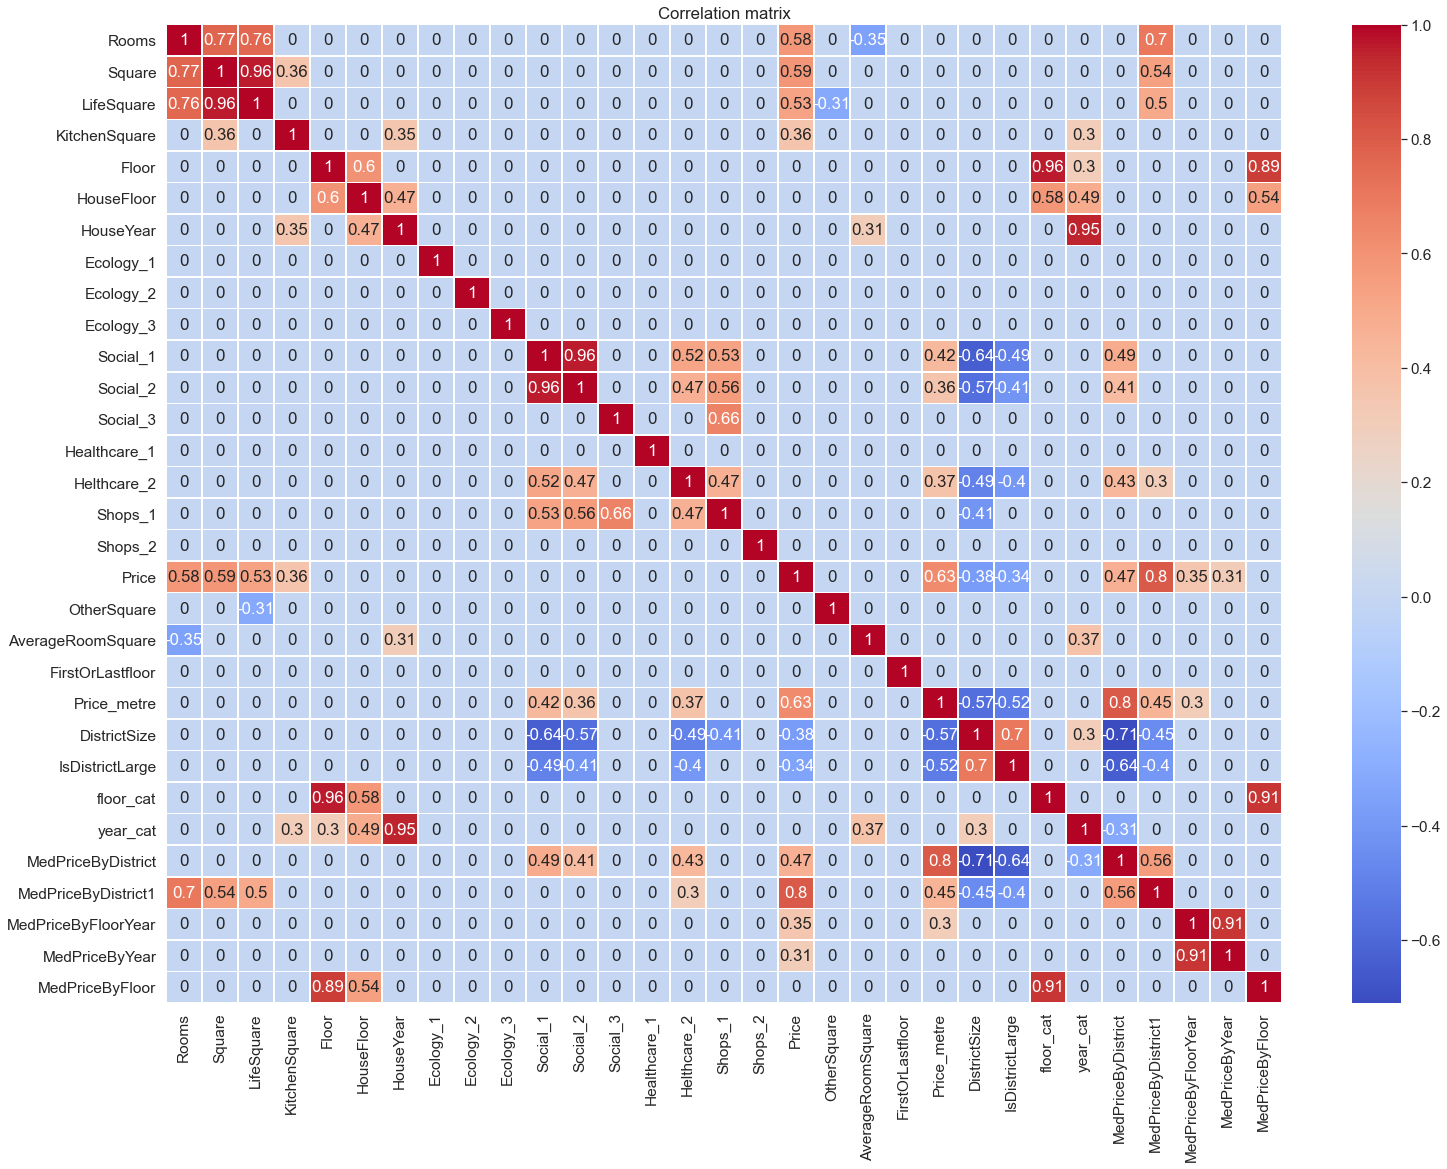

In [26]:
plt.figure(figsize = (25,18))

sns.set(font_scale=1.4)

X_corr = train_df.corr()
X_corr = np.round(X_corr, 2)
X_corr[np.abs(X_corr) < 0.3] = 0

sns.heatmap(X_corr, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [27]:
feature_names = ['DistrictId', 
              #   'Rooms', 
                 'Square',
                 # 'LifeSquare', 
                 'KitchenSquare',  # без него хуже
         #        'Floor', 
         #        'HouseFloor', 
                 'HouseYear', # без него хуже
                 'Ecology_1', # без него хуже
                 'Ecology_2', # чуть хуже
                 'Ecology_3', # без него хуже
                 'Social_1',  # без него хуже
           #      'Social_2', 
                 'Social_3', # без него хуже
                 'Helthcare_2' ,  # без него хуже
           #      'Shops_1' ,
                    'Shops_2'] # без него хуже
                 #'Healthcare_1'

new_feature_names = [#'HouseFloor_outlier', #'HouseYear_outlier', #'LifeSquare_nan', 
                     'DistrictSize', # без него немного хуже
                #        'Price_metre',
              #          'floor_cat',
               #          'year_cat',
            #         'new_district', 
                        'FirstOrLastfloor', # без него хуже
               #         'IsDistrictLarge',  
                        'MedPriceByDistrict',
                        'MedPriceByDistrict1',
                        'MedPriceByYear', # без него хуже
                        'MedPriceByFloor', # без него хуже
                        'MedPriceByFloorYear' # без него хуже
                                                ]
target_name = 'Price'

6. Разбиение на train и test

In [28]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

7. Построение модели

In [30]:
rfr = GradientBoostingRegressor(n_estimators = 280, max_depth = 4, min_samples_split = 2, learning_rate = 0.1, loss = 'ls')
rfr.fit(X_train, y_train.values.ravel())

y_train_preds = rfr.predict(X_train)
y_test_preds = rfr.predict(X_test)

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           7000 non-null   object 
 1   Square               7000 non-null   float64
 2   KitchenSquare        7000 non-null   float64
 3   HouseYear            7000 non-null   int64  
 4   Ecology_1            7000 non-null   float64
 5   Ecology_2            7000 non-null   int64  
 6   Ecology_3            7000 non-null   int64  
 7   Social_1             7000 non-null   int64  
 8   Social_3             7000 non-null   int64  
 9   Helthcare_2          7000 non-null   int64  
 10  Shops_2              7000 non-null   int64  
 11  DistrictSize         7000 non-null   int64  
 12  FirstOrLastfloor     7000 non-null   int64  
 13  MedPriceByDistrict   7000 non-null   float64
 14  MedPriceByDistrict1  7000 non-null   float64
 15  MedPriceByYear       7000 non-null 

Train R2:	0.9
Test R2:	0.786


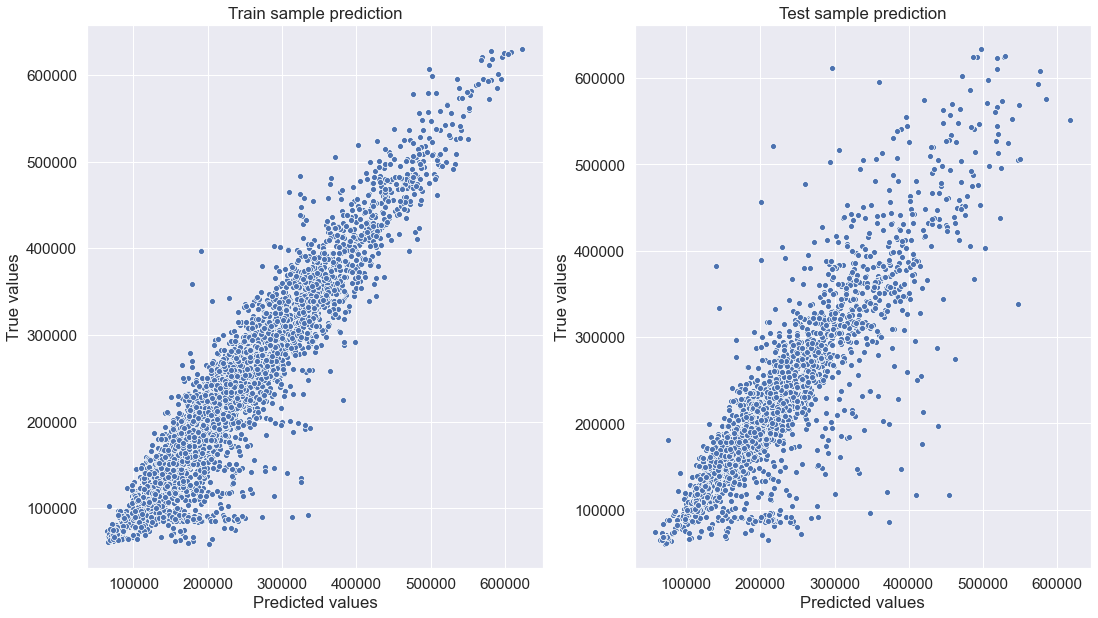

In [32]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [33]:
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_test_preds": y_test_preds.flatten().round(0),
    'difference': abs(y_test - y_test_preds.flatten()).round(0)
})
check_test.nlargest(10, 'difference')

,y_test,y_test_preds,difference
4826,117242.4,454476.0,337233.0
6829,611250.9,296691.0,314560.0
761,521829.6,216594.0,305235.0
416,117667.7,409308.0,291640.0
1494,86108.8,373207.0,287098.0
3781,456417.4,200846.0,255571.0
715,96084.0,347516.0,251432.0
7963,120035.8,370219.0,250183.0
3019,147570.4,390235.0,242665.0
753,381912.2,140331.0,241582.0


In [34]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(check_test["y_test"], check_test["y_test_preds"])//10000)

197930.0


In [35]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(check_test["y_test"], check_test["y_test_preds"])//1)

26935.0


In [36]:
from sklearn.metrics import r2_score

r2_score(check_test["y_test"], check_test["y_test_preds"])

0.7855651846288778

Кросс-валидация

In [37]:
cv_score = cross_val_score(rfr, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
print(cv_score)

[0.79610232 0.78659969 0.79310067 0.78569804 0.78865406]


Важность признаков

In [38]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
14,MedPriceByDistrict1,0.688483
1,Square,0.124626
13,MedPriceByDistrict,0.081500
2,KitchenSquare,0.021241
17,MedPriceByFloorYear,0.017562
7,Social_1,0.017248
3,HouseYear,0.015758
4,Ecology_1,0.008265
0,DistrictId,0.005315
8,Social_3,0.004728


8. Прогнозирование на тестовом датасете

In [39]:
submit = pd.read_csv('sample_submission.csv')

In [40]:
predictions = rfr.predict(test_df)
predictions

array([170664.71273811, 120672.26382239, 141156.80781368, ...,
       149779.74228708, 176423.58817359, 293848.77580517])

In [41]:
submit['Price'] = predictions

In [42]:
submit.to_csv('rf_submit2.csv', index=False)

Проверка датасета

In [43]:
train_df.describe().round(0).transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,2.0,1.0,1.0,1.0,2.0,2.0,5.0
Square,10000.0,56.0,19.0,14.0,42.0,52.0,66.0,276.0
LifeSquare,10000.0,44.0,19.0,1.0,28.0,40.0,55.0,234.0
KitchenSquare,10000.0,8.0,2.0,6.0,6.0,7.0,9.0,20.0
Floor,10000.0,9.0,5.0,1.0,4.0,7.0,12.0,42.0
HouseFloor,10000.0,13.0,6.0,1.0,9.0,14.0,17.0,42.0
HouseYear,10000.0,1985.0,18.0,1910.0,1974.0,1977.0,2001.0,2020.0
Ecology_1,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Ecology_2,10000.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
Ecology_3,10000.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


Докручивание лучших параметров для GradientBoostingRegressor

In [44]:
# from sklearn.model_selection import GridSearchCV
# from pydataset import data
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

In [45]:
# GBR = GradientBoostingRegressor()
# search_grid = {'n_estimators':[280, 300, 320],
#               'max_depth':[4],
#                'learning_rate':[0.065],
#                'loss' : ['ls'] ,
#                'min_samples_split' : [3]         
#               }

In [46]:
# search = GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',cv=5,n_jobs=1)

In [47]:
#search.fit(X_train, y_train.values.ravel())

In [48]:
# search.best_params_

In [49]:
# search.best_score_//10000